Generate Data

In [1]:
import numpy as np
import pandas as pd

num_samples = 50
num_modes = 2
mu = [-2, 0]
sigma = [1, 0.3]
samples = np.zeros(num_samples)

which_mode = np.random.multinomial(1, [1/num_modes]*num_modes, size = num_samples)

for idx_mode in range(num_modes):
    samples_mode = np.random.normal(loc = mu[idx_mode], scale = sigma[idx_mode], size = num_samples) * which_mode[:,idx_mode]
    samples = samples + samples_mode
pd.DataFrame(samples).to_csv("samples_1.csv")

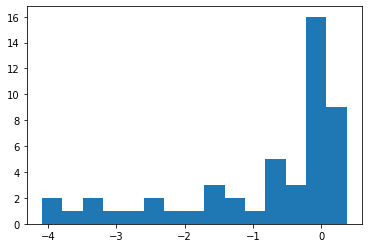

In [2]:
import matplotlib.pyplot as plt

samples = pd.read_csv("samples_1.csv").set_index("Unnamed: 0").to_numpy()

_ = plt.hist(samples, bins = 15)

Inference - MCMC

Priors:
- mean: Normal(0, 10)
- Sigma: Gamma(1,1)

sample mean tf.Tensor([43.329178 32.873905 -8.215626 -5.177249], shape=(4,), dtype=float32)
sample standard deviation tf.Tensor([10.43069   11.144204   3.790887   3.9169457], shape=(4,), dtype=float32)


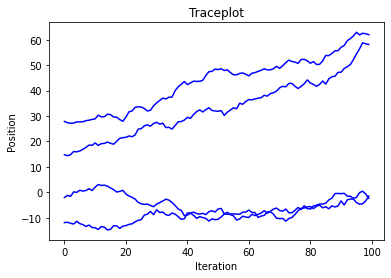

In [109]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import math

tfd = tfp.distributions
dtype = np.float32
data = pd.read_csv("samples_1.csv").set_index("Unnamed: 0").to_numpy()


def target_log_prob(param):
    mu_1, mu_2, sigma_1, sigma_2 = param
    dens = mu_1 + mu_2
    # dens = tf.math.reduce_sum(tf.math.log(
    #     1/(3*tf.math.sqrt(2*math.pi*sigma_1**2)) * tf.math.exp(-0.5*(data - mu_1)**2/sigma_1**2) + 
    #     1/(3*tf.math.sqrt(2*math.pi*sigma_2**2)) * tf.math.exp(-0.5*(data - mu_2)**2/sigma_2**2)) -
    #     1/3 * (mu_1**2 + mu_2**2) - 
    #     (sigma_1**2 + sigma_2**2))
    return(dens)

# Define MALA sampler with `step_size` equal to 0.75
samples = tfp.mcmc.sample_chain(
    num_results=100,
    current_state=dtype([1, 1, 1, 1]),
    kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=target_log_prob,
        step_size=0.75),
    num_burnin_steps=50,
    trace_fn=None,
    seed=42)

sample_mean = tf.reduce_mean(samples, axis=0)
sample_std = tf.sqrt(
    tf.reduce_mean(
        tf.math.squared_difference(samples, sample_mean),
        axis=0))

print('sample mean', sample_mean)
print('sample standard deviation', sample_std)

plt.title('Traceplot')
plt.plot(samples.numpy(), 'b')
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.show()


In [39]:

def target_log_prob(param):
    mu_1, mu_2, sigma_1, sigma_2 = param
    dens = np.sum(np.log(
        1/(2*np.sqrt(2*math.pi*sigma_1**2)) * np.exp(-(data - mu_1)**2/sigma_1**2) + 
        1/(2*np.sqrt(2*math.pi*sigma_2**2)) * np.exp(-(data - mu_2)**2/sigma_2**2))) - 1/2 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2)
    return(dens)

In [91]:
import numpy as np
import math

data = pd.read_csv("samples_1.csv").set_index("Unnamed: 0").to_numpy()


def target_prob(param):
    mu_1, mu_2, sigma_1, sigma_2 = param

    if sigma_1 <= 0 or sigma_2 <= 0:
        dens = 0
    else:
        dens = np.exp(np.sum(np.log(
                1/(2*np.sqrt(2*math.pi*sigma_1**2)) * np.exp(-(data - mu_1)**2/sigma_1**2) + 
                1/(2*np.sqrt(2*math.pi*sigma_2**2)) * np.exp(-(data - mu_2)**2/sigma_2**2))) - 1/2 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2))
    
    print(dens)
    return(dens)


num_samples = 5000
samples = []
x_init = [1, 1, 1, 1]
x_curr = x_init
acc_count = 0
for t in range(num_samples):

    x_prop = np.random.normal(loc = x_curr, scale = 0.1)
    alpha = target_prob(x_prop)/target_prob(x_curr)

    u = np.random.random(size = 1)

    if u < alpha:
        x_curr = x_prop
        acc_count += 1

    samples.append(x_curr)

print(f"Acceptance Rate: {round(acc_count/num_samples, 2)}")

1.2770047762080103e-138
6.20150781041472e-135
2.8540940703788076e-126
6.20150781041472e-135
8.598440756915382e-91
2.8540940703788076e-126
3.7638371742890155e-80
8.598440756915382e-91
4.708582376933195e-83
3.7638371742890155e-80
4.559702597782869e-84
3.7638371742890155e-80
5.70215743653113e-80
3.7638371742890155e-80
2.9445993149962212e-80
5.70215743653113e-80
1.2191874704232578e-82
5.70215743653113e-80
2.3781420037974057e-85
5.70215743653113e-80
4.8553442833132284e-86
5.70215743653113e-80
1.392483314372112e-74
5.70215743653113e-80
1.061021398775776e-71
1.392483314372112e-74
3.33038139423741e-72
1.061021398775776e-71
1.0063479635538408e-72
1.061021398775776e-71
6.106189356262735e-81
1.0063479635538408e-72
1.7119023591793899e-75
1.0063479635538408e-72
2.865672446598182e-75
1.0063479635538408e-72
6.047109071524521e-67
1.0063479635538408e-72
3.038488401660071e-70
6.047109071524521e-67
1.3270399857912201e-73
6.047109071524521e-67
3.669582836335494e-67
6.047109071524521e-67
2.619353341772356e

In [71]:
alpha

nan

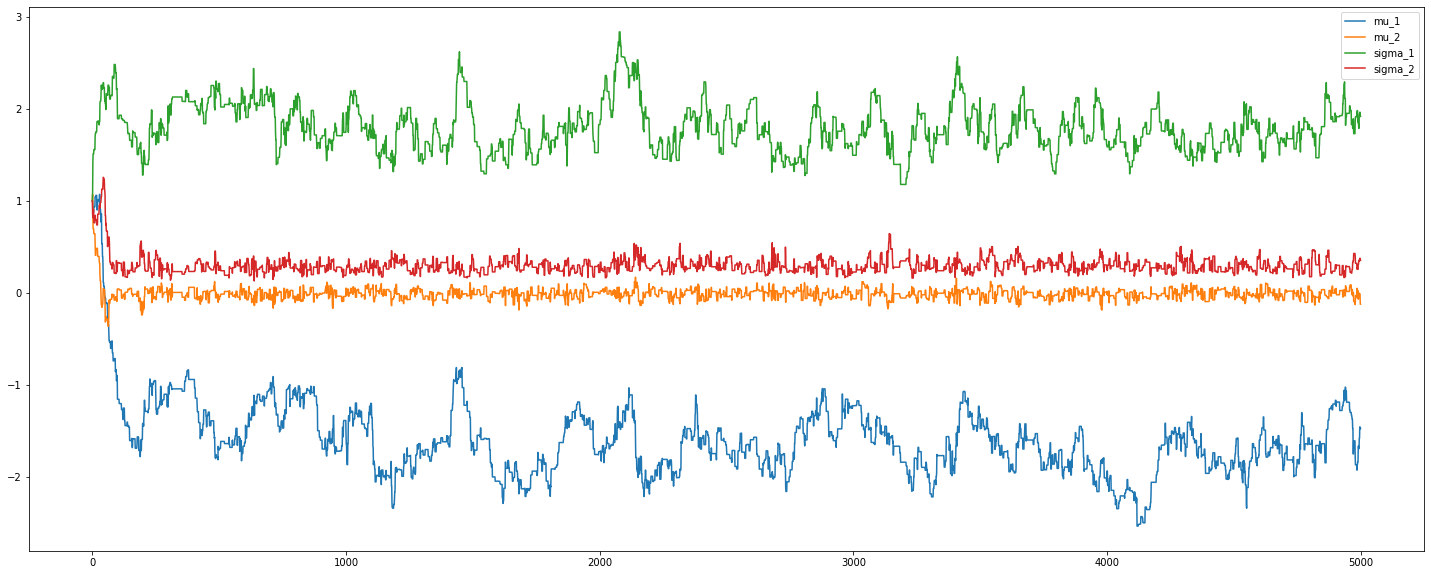

In [92]:
import matplotlib.pyplot as plt

_ = plt.plot(samples)
plt.legend(["mu_1", "mu_2", "sigma_1", "sigma_2"])
plt.rcParams["figure.figsize"] = (25,10)